# Graph Machine Learning

This notebook demonstrates Graph Machine Learning techniques using PyTorch Geometric.

## Learning Objectives
- Manual feature extranction for ML
- Embeddings in lower dimension space
- Understand Graph Neural Networks (GNNs)
- Implement node classification
- Perform link prediction
- Apply graph classification

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# Create a sample graph
G = nx.karate_club_graph()

# === GRAPH-LEVEL FEATURES ===
def extract_graph_features(G):
    """Extract statistical features from entire graph"""
    features = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'avg_clustering': nx.average_clustering(G),
        'transitivity': nx.transitivity(G),
        'diameter': nx.diameter(G) if nx.is_connected(G) else float('inf'),
        'avg_path_length': nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf'),
        'assortativity': nx.degree_assortativity_coefficient(G)
    }
    return features

# Extract graph features
graph_features = extract_graph_features(G)
print("Graph-Level Features:")
for key, value in graph_features.items():
    print(f"  {key}: {value:.4f}")

# === NODE-LEVEL FEATURES ===
def extract_node_features(G):
    """Extract features for each node"""
    # Initialize dictionary to store features
    node_features = {}

    # Degree
    degrees = dict(G.degree())

    # Centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G)
    pagerank = nx.pagerank(G)

    # Local clustering
    clustering = nx.clustering(G)

    # Create feature matrix
    for node in G.nodes():
        node_features[node] = {
            'degree': degrees[node],
            'betweenness': betweenness[node],
            'closeness': closeness[node],
            'eigenvector': eigenvector[node],
            'pagerank': pagerank[node],
            'clustering': clustering[node]
        }

    return pd.DataFrame(node_features).T

# Extract node features
node_features_df = extract_node_features(G)
print("\nNode-Level Features (first 5 nodes):")
print(node_features_df.head())

# Convert to numpy array for ML
X = node_features_df.values
print(f"\nFeature matrix shape: {X.shape}")
print("Ready for machine learning!")

Graph-Level Features:
  num_nodes: 34.0000
  num_edges: 78.0000
  density: 0.1390
  avg_degree: 4.5882
  avg_clustering: 0.5706
  transitivity: 0.2557
  diameter: 5.0000
  avg_path_length: 2.4082
  assortativity: -0.4756

Node-Level Features (first 5 nodes):
   degree  betweenness  closeness  eigenvector  pagerank  clustering
0    16.0     0.437635   0.568966     0.355483  0.088508    0.150000
1     9.0     0.053937   0.485294     0.265954  0.057415    0.333333
2    10.0     0.143657   0.559322     0.317189  0.062767    0.244444
3     6.0     0.011909   0.464789     0.211174  0.037212    0.666667
4     3.0     0.000631   0.379310     0.075966  0.020504    0.666667

Feature matrix shape: (34, 6)
Ready for machine learning!


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Node 0 embedding (first 10 dims): [ 0.03403336 -0.13359596 -0.10428888  0.03715212  0.15274379 -0.02020985
  0.02579761  0.13208827 -0.07528195  0.00960507]
Embedding shape: (64,)

All embeddings shape: (34, 64)


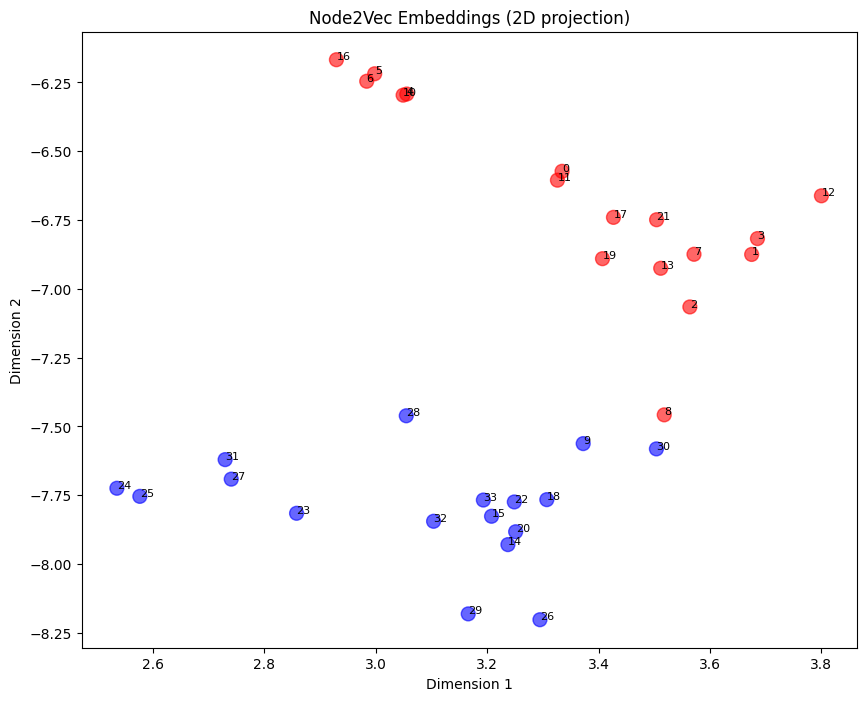


Nodes most similar to node 0:
  Node 5: 0.7650
  Node 10: 0.7587
  Node 17: 0.7584
  Node 4: 0.7529
  Node 6: 0.7372


In [1]:
!pip install node2vec
from node2vec import Node2Vec
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a sample graph
G = nx.karate_club_graph()

# === NODE2VEC EMBEDDING ===
# Initialize Node2Vec
node2vec = Node2Vec(
    G,
    dimensions=64,      # Embedding dimension
    walk_length=30,     # Length of random walk
    num_walks=200,      # Number of walks per node
    p=1,                # Return parameter (BFS vs DFS)
    q=1,                # In-out parameter
    workers=4
)

# Learn embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embedding for a specific node
node_embedding = model.wv[str(0)]  # Embedding for node 0
print(f"Node 0 embedding (first 10 dims): {node_embedding[:10]}")
print(f"Embedding shape: {node_embedding.shape}")

# Get embeddings for all nodes
embeddings = np.array([model.wv[str(i)] for i in G.nodes()])
print(f"\nAll embeddings shape: {embeddings.shape}")

# === VISUALIZE EMBEDDINGS ===
# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get ground truth labels (club membership)
labels = [G.nodes[i]['club'] for i in G.nodes()]
colors = ['red' if label == 'Mr. Hi' else 'blue' for label in labels]

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=colors, s=100, alpha=0.6)
for i, node in enumerate(G.nodes()):
    plt.annotate(str(node),
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=8)
plt.title('Node2Vec Embeddings (2D projection)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# === FIND SIMILAR NODES ===
def find_similar_nodes(model, node, top_k=5):
    """Find most similar nodes to a given node"""
    similar = model.wv.most_similar(str(node), topn=top_k)
    print(f"\nNodes most similar to node {node}:")
    for similar_node, similarity in similar:
        print(f"  Node {similar_node}: {similarity:.4f}")

find_similar_nodes(model, 0, top_k=5)

In [2]:
import networkx as nx
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Create graph
G = nx.karate_club_graph()

# Get labels (0 = Mr. Hi's club, 1 = Officer's club)
labels = np.array([0 if G.nodes[i]['club'] == 'Mr. Hi' else 1
                   for i in G.nodes()])

# === STEP 1: Generate embeddings ===
print("Generating embeddings...")
node2vec = Node2Vec(G, dimensions=64, walk_length=30,
                    num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Get embeddings as feature matrix
X = np.array([model.wv[str(i)] for i in G.nodes()])
print(f"Embedding matrix shape: {X.shape}")

# === STEP 2: Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.3, random_state=42
)

# === STEP 3: Train classifier ===
print("\nTraining classifier...")
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# === STEP 4: Evaluate ===
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Mr. Hi', 'Officer']))

# Compare with using manual features
from sklearn.preprocessing import StandardScaler

# Extract manual features
degrees = dict(G.degree())
betweenness = nx.betweenness_centrality(G)
X_manual = np.array([[degrees[i], betweenness[i]]
                     for i in G.nodes()])

# Scale features
scaler = StandardScaler()
X_manual = scaler.fit_transform(X_manual)

# Split and train
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_manual, labels, test_size=0.3, random_state=42
)
clf_manual = LogisticRegression(random_state=42)
clf_manual.fit(X_train_m, y_train_m)
y_pred_m = clf_manual.predict(X_test_m)
accuracy_manual = accuracy_score(y_test_m, y_pred_m)

print(f"\n=== COMPARISON ===")
print(f"Node2Vec Accuracy: {accuracy:.4f}")
print(f"Manual Features Accuracy: {accuracy_manual:.4f}")
print(f"Improvement: {(accuracy - accuracy_manual)*100:.2f}%")

Generating embeddings...


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Embedding matrix shape: (34, 64)

Training classifier...

Accuracy: 0.9091

Classification Report:
              precision    recall  f1-score   support

      Mr. Hi       1.00      0.80      0.89         5
     Officer       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11


=== COMPARISON ===
Node2Vec Accuracy: 0.9091
Manual Features Accuracy: 0.2727
Improvement: 63.64%


APPROACH 1: GRAPH KERNELS

Created 20 graphs
Class distribution: 13 dense, 7 sparse

Computing kernel matrix (this takes time - O(n²) comparisons)...
  Computed 5/20 rows...
  Computed 10/20 rows...
  Computed 15/20 rows...
  Computed 20/20 rows...

✓ Kernel Matrix Shape: (20, 20)
✓ This is an n×n similarity matrix

Example similarities:
  Graph 0 vs Graph 1: 0.0960
  Graph 0 vs Graph 10: 0.0817

📊 Training Kernel SVM...
✓ Kernel SVM Accuracy: 0.6667

⚠️  LIMITATIONS OF KERNELS:
  - Must compute O(n²) similarities
  - Cannot use with Random Forest, Neural Nets, etc.
  - For new graph, must compare to all training graphs
  - No explicit features to inspect

APPROACH 2: GRAPH EMBEDDINGS

Computing embeddings (fast - O(n) graphs)...
  Embedded 5/20 graphs...
  Embedded 10/20 graphs...
  Embedded 15/20 graphs...
  Embedded 20/20 graphs...

✓ Embedding Matrix Shape: (20, 8)
✓ This is an n×d feature matrix
✓ Each row is an explicit feature vector

Example embeddings:
  Graph 0: [1.6        0

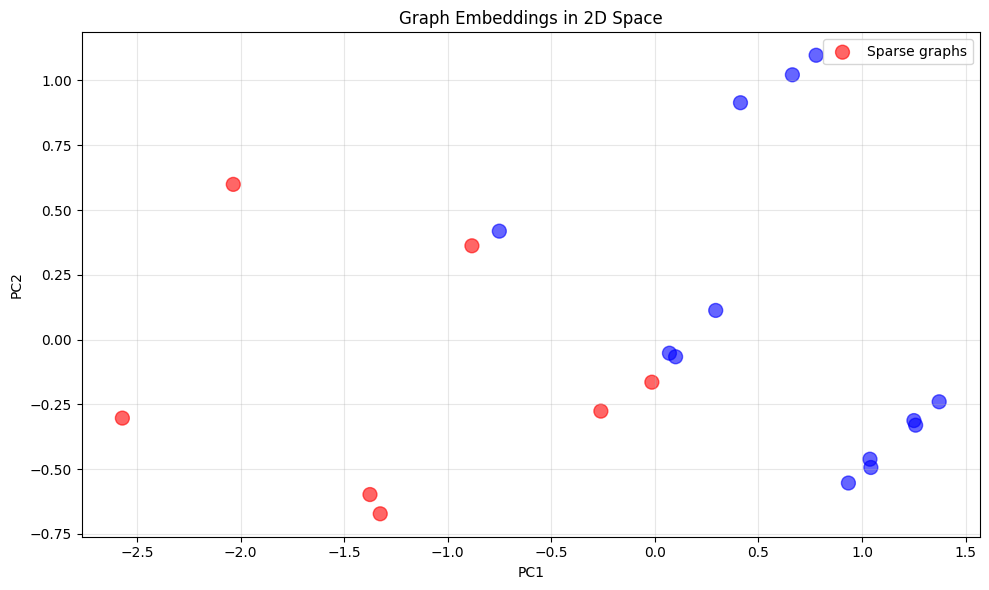

In [3]:
"""
Graph Kernels vs Embeddings: Practical Comparison
Demonstrates the fundamental differences with working code
"""

import networkx as nx
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ===================================================================
# PART 1: GRAPH KERNELS APPROACH
# ===================================================================
print("=" * 60)
print("APPROACH 1: GRAPH KERNELS")
print("=" * 60)

def random_walk_kernel(G1, G2, walk_length=3, num_walks=100):
    """
    Simple random walk kernel implementation
    Returns: similarity score between two graphs
    """
    def random_walk(G, length):
        """Generate a random walk sequence"""
        if len(G.nodes()) == 0:
            return []
        node = np.random.choice(list(G.nodes()))
        walk = [node]
        for _ in range(length - 1):
            neighbors = list(G.neighbors(node))
            if not neighbors:
                break
            node = np.random.choice(neighbors)
            walk.append(node)
        return walk

    # Generate random walks for both graphs
    walks1 = [random_walk(G1, walk_length) for _ in range(num_walks)]
    walks2 = [random_walk(G2, walk_length) for _ in range(num_walks)]

    # Count matching walk patterns (simplified)
    # In practice, use more sophisticated matching
    similarity = 0
    for w1 in walks1:
        for w2 in walks2:
            if len(w1) == len(w2):
                similarity += sum([1 for i in range(len(w1))
                                 if w1[i] == w2[i]]) / len(w1)

    return similarity / (num_walks * num_walks)

# Create sample graphs
graphs = [
    nx.erdos_renyi_graph(10, 0.3, seed=i) for i in range(20)
]

# Create labels (0 = sparse, 1 = dense)
labels = [0 if nx.density(g) < 0.3 else 1 for g in graphs]

print(f"\nCreated {len(graphs)} graphs")
print(f"Class distribution: {sum(labels)} dense, {len(labels)-sum(labels)} sparse")

# Compute kernel matrix (similarity matrix)
print("\nComputing kernel matrix (this takes time - O(n²) comparisons)...")
n = len(graphs)
K = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        similarity = random_walk_kernel(graphs[i], graphs[j])
        K[i, j] = similarity
        K[j, i] = similarity  # Symmetric
    if (i + 1) % 5 == 0:
        print(f"  Computed {i+1}/{n} rows...")

print("\n✓ Kernel Matrix Shape:", K.shape)
print("✓ This is an n×n similarity matrix")
print("\nExample similarities:")
print(f"  Graph 0 vs Graph 1: {K[0, 1]:.4f}")
print(f"  Graph 0 vs Graph 10: {K[0, 10]:.4f}")

# Train with kernel SVM
print("\n📊 Training Kernel SVM...")
X_train_idx, X_test_idx = train_test_split(
    range(len(graphs)), test_size=0.3, random_state=42
)

# Create kernel matrices for train/test
K_train = K[np.ix_(X_train_idx, X_train_idx)]
K_test = K[np.ix_(X_test_idx, X_train_idx)]

y_train = [labels[i] for i in X_train_idx]
y_test = [labels[i] for i in X_test_idx]

# Kernel SVM expects precomputed kernel
clf_kernel = SVC(kernel='precomputed')
clf_kernel.fit(K_train, y_train)
y_pred_kernel = clf_kernel.predict(K_test)

acc_kernel = accuracy_score(y_test, y_pred_kernel)
print(f"✓ Kernel SVM Accuracy: {acc_kernel:.4f}")

print("\n⚠️  LIMITATIONS OF KERNELS:")
print("  - Must compute O(n²) similarities")
print("  - Cannot use with Random Forest, Neural Nets, etc.")
print("  - For new graph, must compare to all training graphs")
print("  - No explicit features to inspect")

# ===================================================================
# PART 2: GRAPH EMBEDDINGS APPROACH
# ===================================================================
print("\n" + "=" * 60)
print("APPROACH 2: GRAPH EMBEDDINGS")
print("=" * 60)

def graph_embedding_simple(G, dim=8):
    """
    Simple graph embedding using aggregated node features
    Returns: explicit d-dimensional vector
    """
    if len(G.nodes()) == 0:
        return np.zeros(dim)

    # Compute node-level statistics
    degrees = dict(G.degree())
    clustering = nx.clustering(G)

    # Create graph-level features by aggregation
    features = []

    # Degree statistics
    degree_values = list(degrees.values())
    features.extend([
        np.mean(degree_values),
        np.std(degree_values),
        np.max(degree_values),
        np.min(degree_values)
    ])

    # Clustering statistics
    clustering_values = list(clustering.values())
    features.extend([
        np.mean(clustering_values),
        np.std(clustering_values)
    ])

    # Global properties
    features.extend([
        nx.density(G),
        G.number_of_edges() / max(G.number_of_nodes(), 1)
    ])

    return np.array(features)

# Create embedding matrix
print("\nComputing embeddings (fast - O(n) graphs)...")
embeddings = []
for i, g in enumerate(graphs):
    emb = graph_embedding_simple(g, dim=8)
    embeddings.append(emb)
    if (i + 1) % 5 == 0:
        print(f"  Embedded {i+1}/{len(graphs)} graphs...")

X = np.array(embeddings)

print("\n✓ Embedding Matrix Shape:", X.shape)
print("✓ This is an n×d feature matrix")
print("✓ Each row is an explicit feature vector")

print("\nExample embeddings:")
print(f"  Graph 0: {X[0]}")
print(f"  Graph 1: {X[1]}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.3, random_state=42
)

# ===================================================================
# NOW WE CAN USE ANY ML ALGORITHM!
# ===================================================================
print("\n📊 Training multiple classifiers with embeddings...")

# 1. SVM (with RBF kernel on embeddings)
from sklearn.svm import SVC
clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)
acc_svm = accuracy_score(y_test, clf_svm.predict(X_test))
print(f"  ✓ SVM Accuracy: {acc_svm:.4f}")

# 2. Random Forest (cannot use with kernel matrix!)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, clf_rf.predict(X_test))
print(f"  ✓ Random Forest Accuracy: {acc_rf:.4f}")

# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))
print(f"  ✓ Logistic Regression Accuracy: {acc_lr:.4f}")

# 4. k-NN
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)
acc_knn = accuracy_score(y_test, clf_knn.predict(X_test))
print(f"  ✓ k-NN Accuracy: {acc_knn:.4f}")

print("\n✨ ADVANTAGES OF EMBEDDINGS:")
print("  - Fast O(n) computation")
print("  - Work with ANY ML algorithm")
print("  - For new graph, just embed it once")
print("  - Can inspect and visualize features")

# ===================================================================
# PART 3: VISUALIZING EMBEDDINGS
# ===================================================================
print("\n" + "=" * 60)
print("VISUALIZING EMBEDDINGS")
print("=" * 60)

from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
colors = ['red' if l == 0 else 'blue' for l in labels]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=100, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Graph Embeddings in 2D Space')
plt.legend(['Sparse graphs', 'Dense graphs'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('embeddings_visualization.png', dpi=150, bbox_inches='tight')
print("✓ Saved visualization to 'embeddings_visualization.png'")
print("  Similar graphs are close together in embedding space!")

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 60)
print("SUMMARY: KERNELS vs EMBEDDINGS")
print("=" * 60)

print("\n📊 OUTPUTS:")
print(f"  Kernel Matrix:     {K.shape} (n×n similarities)")
print(f"  Embedding Matrix:  {X.shape} (n×d features)")

print("\n⚡ SPEED:")
print(f"  Kernels:    O(n²) = {n*n} comparisons")
print(f"  Embeddings: O(n)  = {n} embeddings")

print("\n🤖 ML COMPATIBILITY:")
print("  Kernels:    Can ONLY use kernel methods (Kernel SVM)")
print("  Embeddings: Can use ANY algorithm (RF, NN, k-NN, etc.)")

print("\n🎯 WHEN TO USE:")
print("  Kernels:    Small datasets, kernel methods, need theory")
print("  Embeddings: Large datasets, any ML pipeline, need speed")

print("\n✨ KEY INSIGHT:")
print("  - Kernels: Give you SIMILARITIES (implicit features)")
print("  - Embeddings: Give you FEATURES (explicit vectors)")
print("  - Both capture graph structure, just differently!")

In [ ]:
# Install required packages (uncomment if needed)
# !pip install torch torch-geometric torch-scatter torch-sparse

# Import required libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid, KarateClub
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

## 1. Introduction to Graph Neural Networks

Let's start with a simple GNN implementation.

In [ ]:
# Simple GCN implementation
class SimpleGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second GCN layer
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

print("Simple GCN model created successfully!")

## 2. Node Classification

Let's implement node classification using the Cora dataset.

In [ ]:
# Load Cora dataset
try:
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]
    print(f"Dataset: {dataset}")
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
    print(f"Number of training nodes: {data.train_mask.sum()}")
    print(f"Number of validation nodes: {data.val_mask.sum()}")
    print(f"Number of test nodes: {data.test_mask.sum()}")
except Exception as e:
    print(f"Error loading Cora dataset: {e}")
    print("Creating a simple synthetic dataset instead...")

    # Create synthetic data
    num_nodes = 100
    num_features = 16
    num_classes = 7

    # Random features
    x = torch.randn(num_nodes, num_features)

    # Random edges
    edge_index = torch.randint(0, num_nodes, (2, 200))

    # Random labels
    y = torch.randint(0, num_classes, (num_nodes,))

    # Create masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[:70] = True
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask[70:85] = True
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask[85:] = True

    data = Data(x=x, edge_index=edge_index, y=y,
               train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    print(f"Synthetic dataset created with {num_nodes} nodes and {num_classes} classes")

In [ ]:
# Train the GCN model
def train_gcn(data, epochs=200):
    model = SimpleGCN(data.num_features, data.y.max().item() + 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d}: Loss: {loss.item():.4f}')

    return model, losses

# Train the model
model, losses = train_gcn(data)
print("Training completed!")

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Calculate accuracies
    train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    val_acc = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Validation Accuracy: {val_acc:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Graph Attention Networks (GAT)

Let's implement a Graph Attention Network.

In [ ]:
# GAT implementation
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(8 * num_heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("GAT model created successfully!")

## 4. Summary and Key Insights

### Key Takeaways:

1. **Graph Neural Networks**: Extend neural networks to graph-structured data
2. **Message Passing**: Nodes aggregate information from their neighbors
3. **Attention Mechanisms**: GAT uses attention to weight neighbor importance
4. **Node Classification**: Predict node labels using graph structure and features

### Applications:
- **Social Networks**: User classification, recommendation systems
- **Biological Networks**: Protein function prediction, drug discovery
- **Knowledge Graphs**: Entity classification, relation extraction
- **Computer Vision**: Scene understanding, object detection